In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("DiabetesPredictionPipeline").getOrCreate()

# Load the dataset
data_path = "diabetes_prediction_dataset.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Columns for features and label
numerical_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'smoking_history']
label_col = 'diabetes'

# Preprocessing for Numerical Features
num_assembler = VectorAssembler(inputCols=numerical_features, outputCol="num_features")
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features")

# Preprocessing for Categorical Features
stages = []  # this will collect all the stages in our pipeline
for categoricalCol in categorical_features:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# Combine all processed numerical and categorical features into a single feature vector
assembler_inputs = [c + "classVec" for c in categorical_features] + ["scaled_num_features"]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [num_assembler, scaler, assembler]

# Random Forest Classifier
rf = RandomForestClassifier(labelCol=label_col, featuresCol="features")
stages += [rf]

# Create the pipeline with all stages
pipeline = Pipeline(stages=stages)

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10]) \
    .addGrid(rf.maxDepth, [5]) \
    .build()

# CrossValidator for Model Selection
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction"),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(df)

# Model Evaluation
predictions = cvModel.transform(df)
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test set accuracy = " + str(accuracy))

# Stop the session
spark.stop()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/30 17:13:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Test set accuracy = 0.97187


In [2]:
import time

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("DiabetesPredictionPipeline").getOrCreate()

# Load the dataset
data_path = "diabetes_prediction_dataset.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Columns for features and label
numerical_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'smoking_history']
label_col = 'diabetes'

# Stages
stages = []
stage_times = []

# Data Preprocessing for Numerical Features
num_assembler = VectorAssembler(inputCols=numerical_features, outputCol="num_features")
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features")

# Data Preprocessing for Categorical Features
for categoricalCol in categorical_features:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# Combine all processed numerical and categorical features into a single feature vector
assembler_inputs = [c + "classVec" for c in categorical_features] + ["scaled_num_features"]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [num_assembler, scaler, assembler]



# Apply each stage manually and time them
for stage in stages:
    start_time = time.perf_counter()
    
    # For estimators (like StringIndexer, OneHotEncoder, and StandardScaler), fit and then transform
    if isinstance(stage, StringIndexer) or isinstance(stage, OneHotEncoder) or isinstance(stage, StandardScaler):
        model = stage.fit(df)
        df = model.transform(df)
    else:  # For transformers (like VectorAssembler), just transform
        df = stage.transform(df)

    end_time = time.perf_counter()
    stage_times.append((stage.__class__.__name__, end_time - start_time))

# Random Forest Classifier
rf = RandomForestClassifier(labelCol=label_col, featuresCol="features")

# Now apply CrossValidator
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10]) \
    .addGrid(rf.maxDepth, [5]) \
    .build()



crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction"),
                          numFolds=5)

start_time = time.perf_counter()
cvModel = crossval.fit(df)
end_time = time.perf_counter()
stage_times.append(("CrossValidator", end_time - start_time))

# Print out the stage times
for stage_name, timing in stage_times:
    print(f"{stage_name} took {timing:.8f} seconds")

# Model Evaluation (this is part of CrossValidator timing)
predictions = cvModel.transform(df)
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

# Stop the session
spark.stop()


StringIndexer took 0.18328208 seconds
OneHotEncoder took 0.01272358 seconds
StringIndexer took 0.13581829 seconds
OneHotEncoder took 0.01098850 seconds
VectorAssembler took 0.00477450 seconds
StandardScaler took 0.24458021 seconds
VectorAssembler took 0.00570496 seconds
CrossValidator took 10.03796492 seconds
Test set accuracy = 0.97187


In [3]:
import os
scale = os.getenv('SCALE', 0)
scale

0

In [14]:
os.getcwd()+"/data"

'/Users/anishmitagar/Documents/College/FA23/CS532/Final Project/data'

['/Users/anishmitagar/Documents/College/FA23/CS532/Final Project/data/results_num_node_1.csv', '/Users/anishmitagar/Documents/College/FA23/CS532/Final Project/data/results_num_node_2.csv']
['/Users/anishmitagar/Documents/College/FA23/CS532/Final Project/data/results_num_node_1.csv', '/Users/anishmitagar/Documents/College/FA23/CS532/Final Project/data/results_num_node_2.csv']


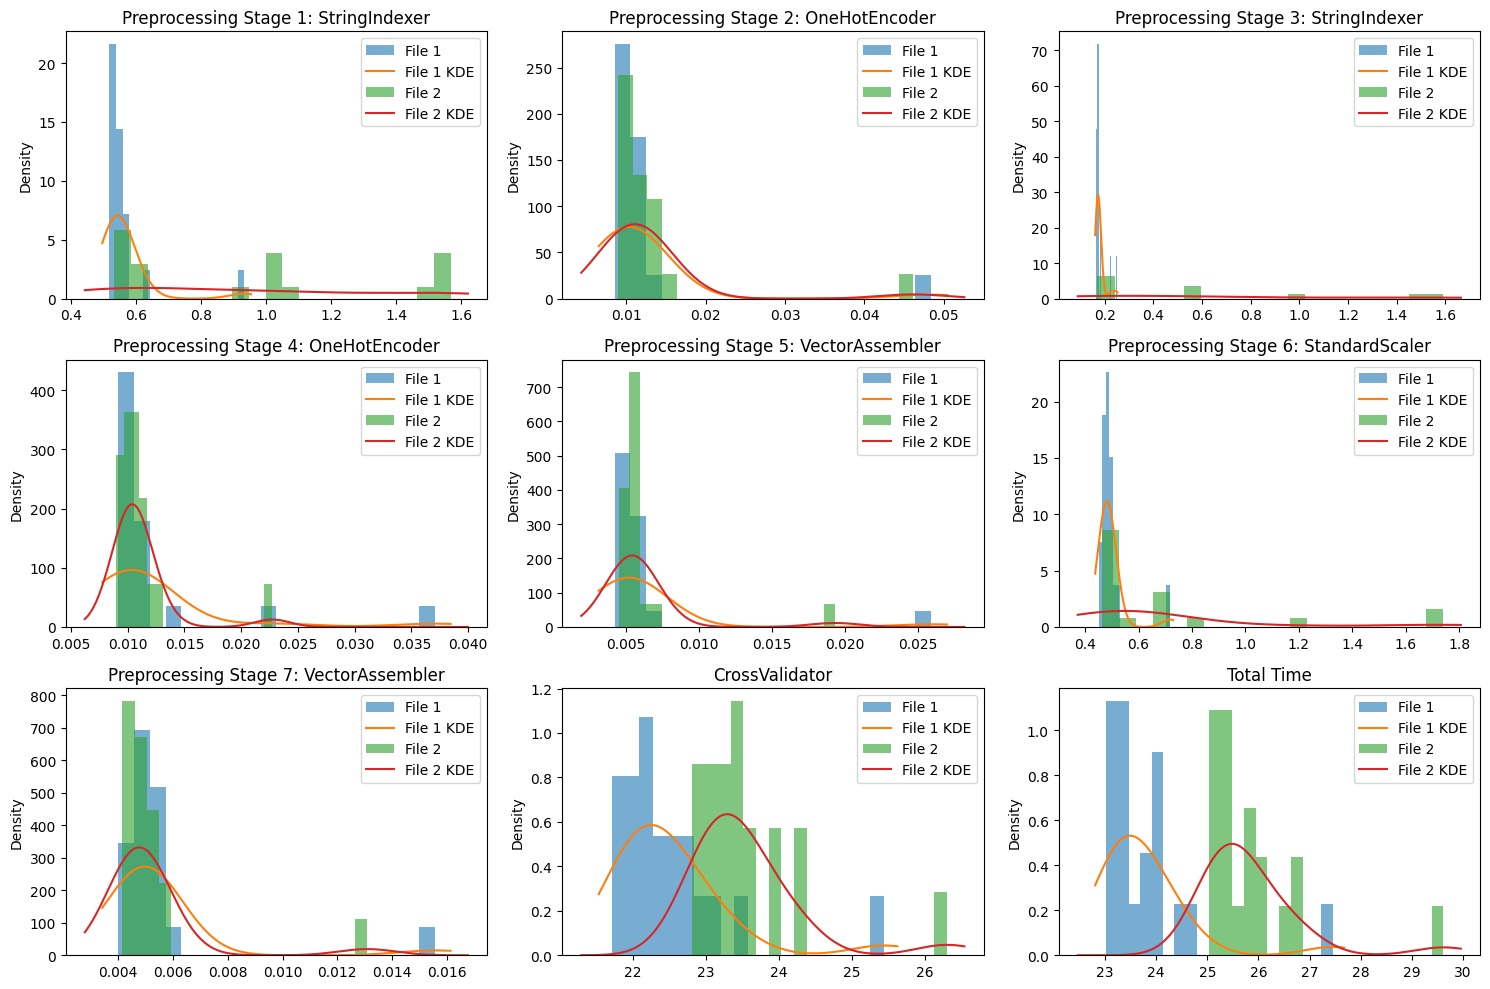

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import glob

# List of CSV file paths
csv_files = glob.glob(os.getcwd() + "/data" + '/*.csv')  # Modify this path to your CSV files directory

# Columns to be compared
columns = [
    "Preprocessing Stage 1: StringIndexer",
    "Preprocessing Stage 2: OneHotEncoder",
    "Preprocessing Stage 3: StringIndexer",
    "Preprocessing Stage 4: OneHotEncoder",
    "Preprocessing Stage 5: VectorAssembler",
    "Preprocessing Stage 6: StandardScaler",
    "Preprocessing Stage 7: VectorAssembler",
    "CrossValidator",
    "Total Time"
]

# Read each CSV file and store data for each column
data_per_column = {column: [] for column in columns}

print(csv_files)

csv_files = [os.getcwd() + "/data/results_num_node_1.csv", os.getcwd() + "/data/results_num_node_2.csv"]
print(csv_files)
for file in csv_files:
    df = pd.read_csv(file)
    for column in columns:
        if column in df.columns:
            data_per_column[column].append(df[column])

# Plotting the data
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)
    for j, data in enumerate(data_per_column[column]):
        label = f"File {j+1}"  # Label each dataset by file number
        # Plot histogram
        plt.hist(data, bins=20, density=True, alpha=0.6, label=label)
        # Plot KDE
        mn, mx = plt.xlim()
        kde_xs = np.linspace(mn, mx, 301)
        kde = st.gaussian_kde(data)
        plt.plot(kde_xs, kde.pdf(kde_xs), label=f"{label} KDE")
    plt.title(column)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()